## Visualize Linear Pieces of different layers

In [1]:
import torch
import matplotlib.pyplot as plt
import math, time
import numpy as np
from sparsemax import Sparsemax
import torch.nn as nn
from matplotlib.colors import Normalize, hsv_to_rgb

In [2]:
#define parameters
dimin = 2
numneuro = 5

In [3]:

#build a model with 2 inputs, 5 hidden neurons, and 2 outputs
class Net(torch.nn.Module):
    def __init__(self, dimin=2, numneuro=5, dimout=2, nonlinearity='relu', topk=None):
        super(Net, self).__init__()
        self.nonlinearity = nonlinearity
        self.numneuro = numneuro
        self.dimin = dimin
        if topk is not None:
            self.topk = topk
        self.fc1 = torch.nn.Linear(dimin, numneuro)
        self.fc2 = torch.nn.Linear(numneuro, dimout)
    def forward(self, x, return_hidden=False):
        if self.nonlinearity=='relu':
            fact = nn.ReLU()
            xint = fact((1/self.dimin)*self.fc1(x))
        elif self.nonlinearity=='topk':
            xint = self.fc1(x)
            _, topk_indices = torch.topk(xint, self.topk, dim=-1)
            mask = torch.zeros_like(xint)
            mask.scatter_(-1, topk_indices, 1)
            xint = xint * mask* (1/self.dimin)
        elif self.nonlinearity=='sparsemax_lintx':
            xint = self.fc1(x)
            sm = Sparsemax(dim=-1)
            xint = sm((1/self.dimin)*xint)
        elif self.nonlinearity=='sparsemax_dist':
            A = self.fc1.weight
            b = self.fc1.bias
            xint = -(1/self.dimin)*torch.square(torch.norm(x.unsqueeze(1)-A.unsqueeze(0), dim=-1))
            sm = Sparsemax(dim=-1)
            xint = sm(xint)
        x = self.fc2(xint)
        if not return_hidden:
            return x
        else:
            return x, xint

In [4]:
def linear_pieces(model, data, neuron_colors, receptive_fields=False, activation_heatmaps=False):
    _, hidden = model(data, return_hidden=True)
    Mact = (hidden>0).float()
    dims = math.ceil(math.sqrt(data.shape[0]))
    linpieces = np.dot(Mact.numpy(), neuron_colors)
    norm = Normalize()
    linpieces = norm(linpieces)
    linpieces = linpieces.reshape(dims, dims, 3).transpose(1, 0, 2)

    if receptive_fields:
        Rfall = []
        for k in range(model.numneuro):
            Rf = torch.zeros_like(Mact)
            Rf[:, k] = Mact[:, k]
            Rf = np.dot(Rf.numpy(), neuron_colors)
            norm = Normalize()
            Rf = norm(Rf)
            Rf = Rf.reshape(dims, dims, 3).transpose(1, 0, 2)
            Rfall.append(Rf)
    
    if not receptive_fields:
        return linpieces
    else:
        return linpieces, Rfall

In [5]:
torch.manual_seed(2)

model = Net(dimin, numneuro, nonlinearity='relu')
model2 = Net(dimin, numneuro, nonlinearity='topk', topk=2)
model3 = Net(dimin, numneuro, nonlinearity='sparsemax_lintx')
model4 = Net(dimin, numneuro, nonlinearity='sparsemax_dist')
modelsall = [model, model2, model3, model4]
titles_all = ['relu', 'top2', 'sparsemax-lintx', 'sparsemax-dist']



In [6]:
torch.manual_seed(2)

SAME_WEIGHT_INIT = True
if SAME_WEIGHT_INIT:
    A = torch.randn_like(model.fc1.weight)
    b = torch.randn_like(model.fc1.bias)
    for modelk in modelsall:
        with torch.no_grad():
            modelk.fc1.weight.copy_(A)
            modelk.fc1.bias.copy_(b)

In [7]:
#create a meshgrid of points from [-5, 5] in 2D, save as a tensor of size (2, 100*100)
x, y = torch.meshgrid(torch.linspace(-5, 5, 1000), torch.linspace(-5, 5, 1000))
Xdata = torch.stack([x, y], dim=2).view(-1, 2)
    

/n/holylabs/LABS/ba_lab/Users/sumedh/conda/envs/spmax/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
np.random.seed(1)
hues = np.linspace(0, 1, numneuro, endpoint=False)  # Evenly spaced hues
hues = np.random.permutation(hues)  # Randomize order
saturation = 0.9  # High saturation for vibrant colors
value = 0.9  # High brightness
neuron_colors = hsv_to_rgb(np.array([[h, saturation, value] for h in hues]))  # Convert to RGB

In [9]:
linpieces_all = []
rf_all = []
for k in range(len(modelsall)):
    linpieces, rf = linear_pieces(modelsall[k], Xdata, neuron_colors, receptive_fields=True)
    linpieces_all.append(linpieces)
    rf_all.append(rf)


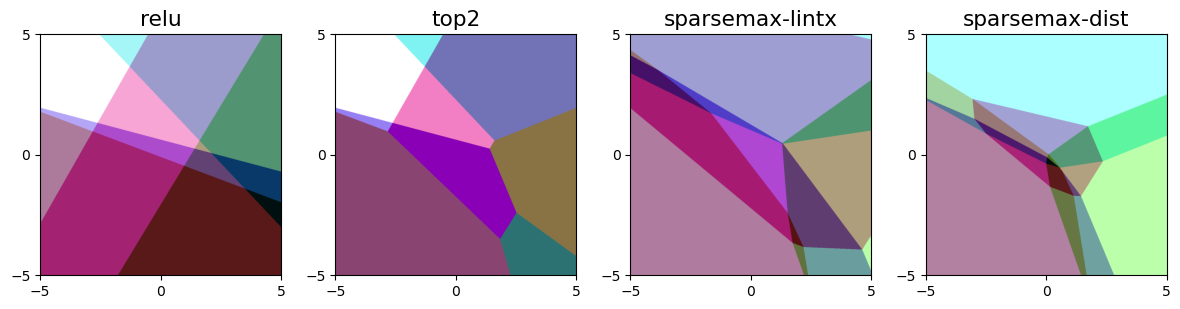

In [10]:
fig, ax = plt.subplots(1, len(modelsall), figsize=(3*len(modelsall), 5))
plt.rcParams.update({'font.size': 13})
for k in range(len(modelsall)):
    ax[k].imshow(linpieces_all[k].max()-linpieces_all[k], extent=(-5, 5, -5, 5), origin='lower')
    ax[k].set_title(titles_all[k])
    ax[k].set_xlim(-5, 5)
    ax[k].set_ylim(-5, 5)
    ax[k].set_yticks([-5, 0, 5])
    ax[k].set_xticks([-5, 0, 5])
# fig.suptitle("Piecewise linear regions", y=0.9)
fig.tight_layout()
# plt.savefig('./figures/piecewise_linear_regions.png', dpi=300, bbox_inches='tight')

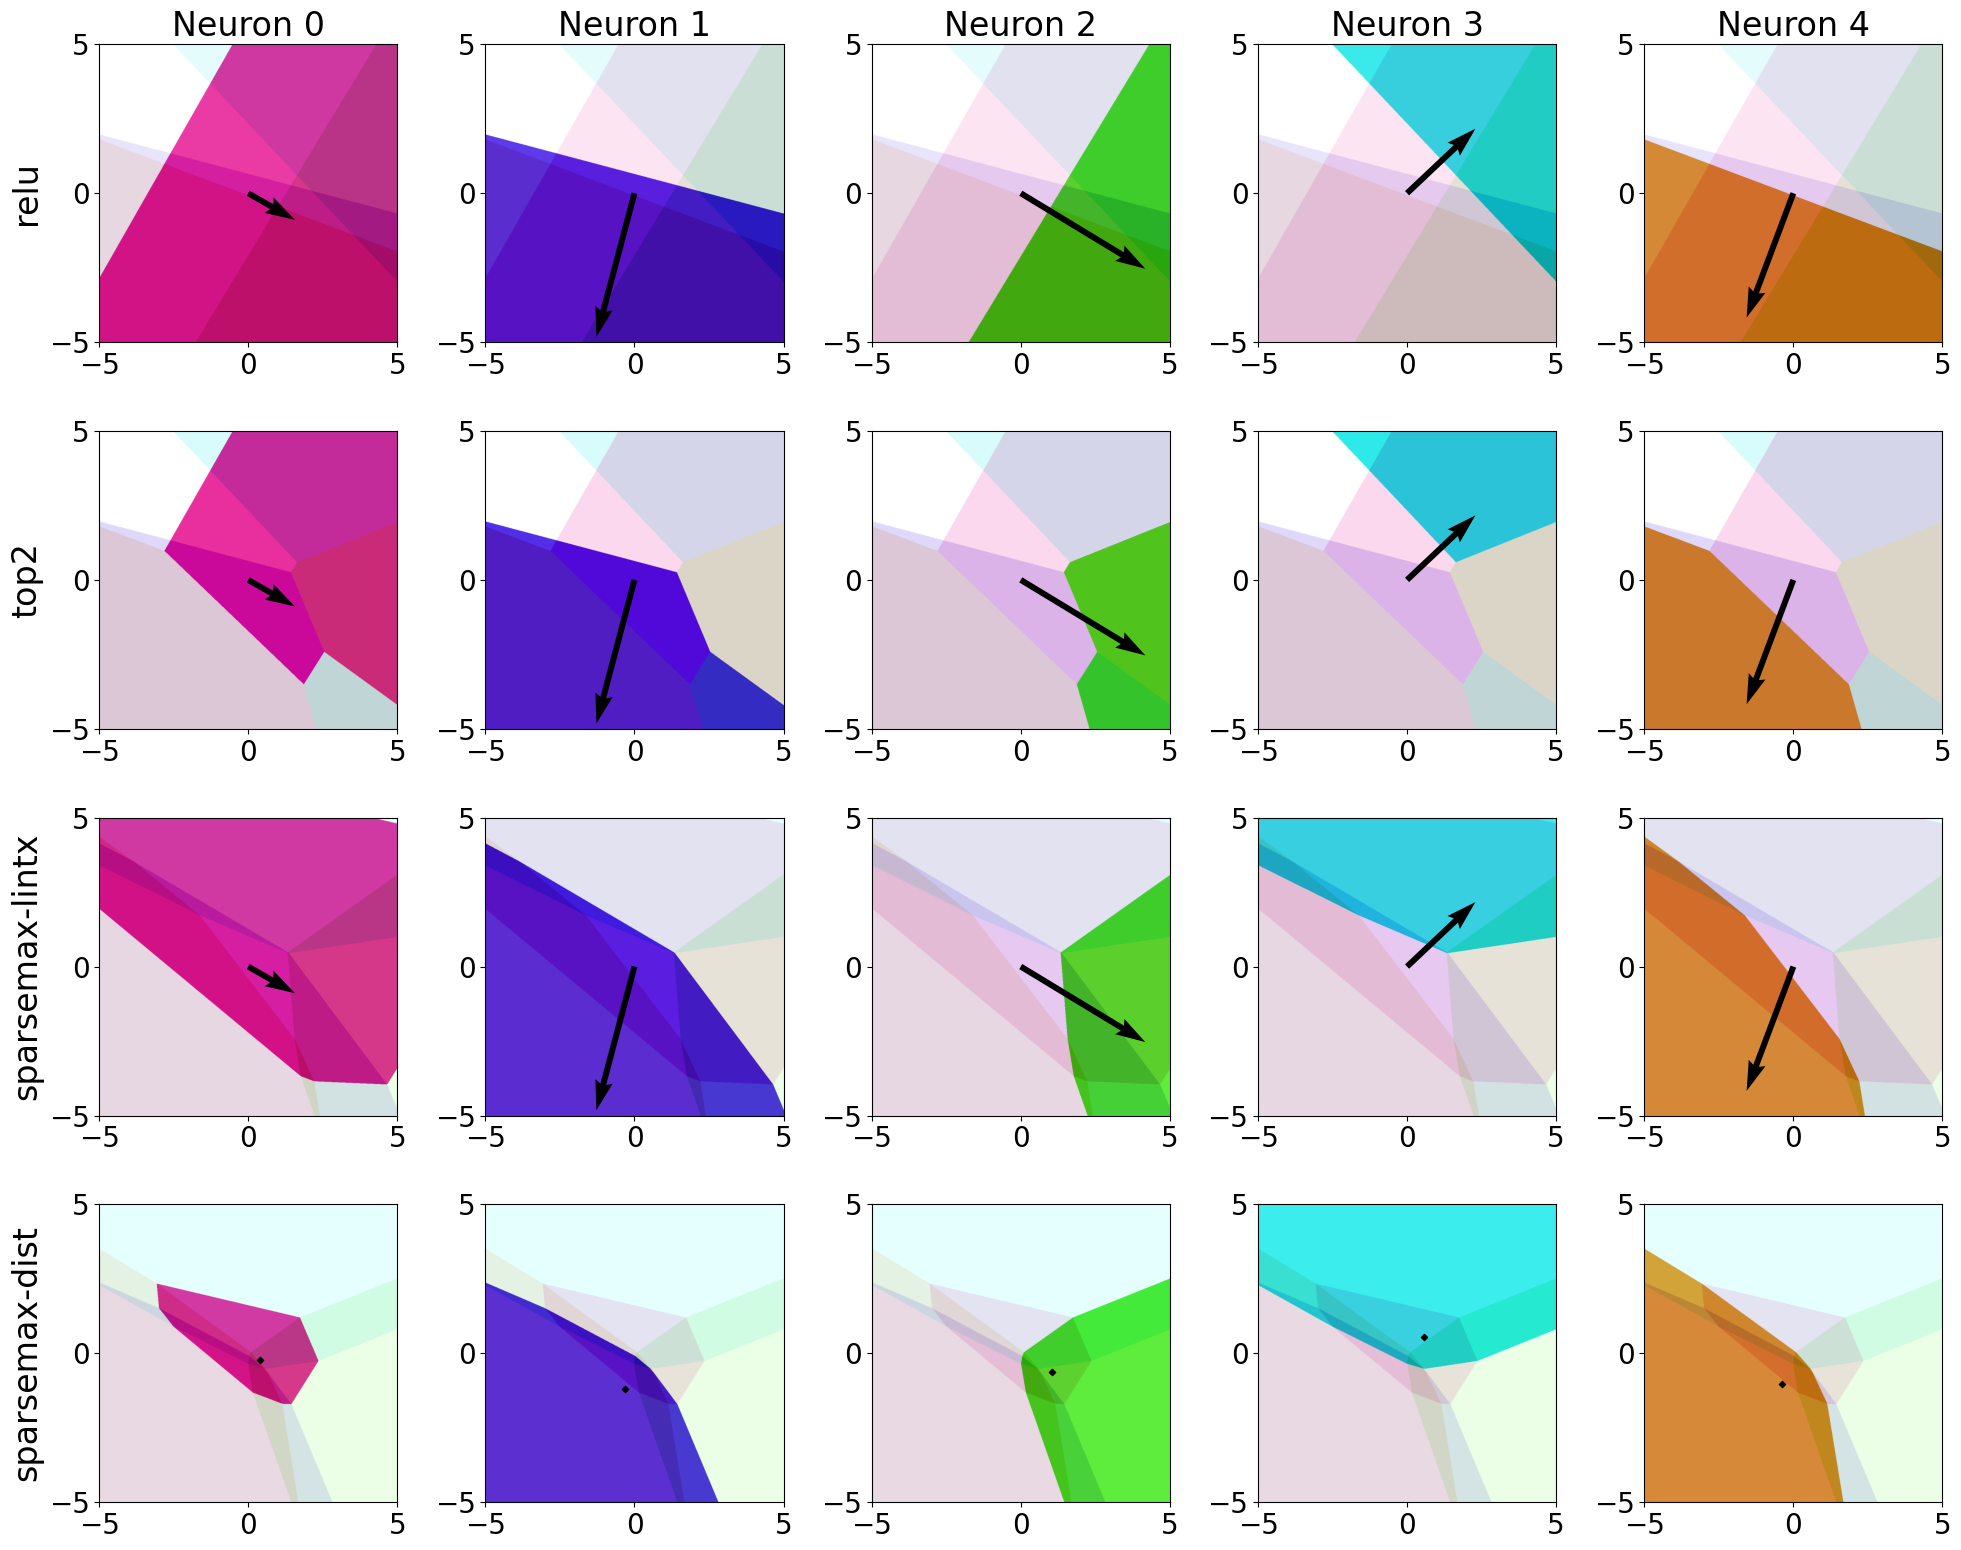

In [14]:
# len(modelsall) rows, numneuro cols of subplots, each showing the receptive field of a hidden neuron
fig, ax = plt.subplots(len(modelsall), numneuro, figsize=(4*numneuro, 4*len(modelsall)))
#text size increase
plt.rcParams.update({'font.size': 20})
fig.subplots_adjust(hspace=0.1/2, wspace=0.1/2)
for k in range(len(modelsall)):
    for i in range(numneuro):
        ax[k, i].imshow(rf_all[k][i].max()-rf_all[k][i], extent=(-5, 5, -5, 5), origin='lower', alpha=0.95)
        
        ax[k, i].set_xlim(-5, 5)
        ax[k, i].set_ylim(-5, 5)
        ax[k,i].set_xticks([-5, 0, 5])
        ax[k,i].set_yticks([-5, 0, 5])
        # Overlay the linear pieces as lighter plots on the corresponding receptive fields
        ax[k, i].imshow(linpieces_all[k].max()-linpieces_all[k], extent=(-5, 5, -5, 5), origin='lower', alpha=0.3)
        if i==0:
            ax[k,0].set_ylabel(titles_all[k], size='large')
        if k==0:
            ax[0,i].set_title(f"Neuron {i}")
        #show weight vector of hidden neuron
        if k!=len(modelsall)-1:
            vec = modelsall[k].fc1.weight[i, :].detach().numpy()
            bias = modelsall[k].fc1.bias[i].detach().numpy()
            # vec = (-bias/np.square(np.linalg.norm(vec)))*vec #scale to make tip touch the separator hyperplane
            # vec = 5*vec/np.linalg.norm(vec) #dividing by norm loses info
            vec = 4*vec
            ax[k, i].quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy',color='k',width=0.02)
        else: #sparsemax-dist case, show weight vector as a point cloud
            vec = modelsall[k].fc1.weight[i, :].detach().numpy()
            # vec = vec/np.linalg.norm(vec)
            ax[k, i].scatter(vec[0], vec[1], c='k', s=10, marker='D')
# fig.suptitle("Receptive fields of hidden neurons")
fig.tight_layout()
# plt.savefig('./figures/receptive_fields.png', dpi=300, bbox_inches='tight')